# T5 tuning & inference



As you can see, GPT2 fails to be finetuned on small amount of data due to different nature at the root of the algorithm. That's why I decided to take a look at T5 model. 

The T5 model was proposed in the work: ["Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer"](https://arxiv.org/pdf/1910.10683.pdf). The idea behind this model is to explore the insights regarding transfer learning and creating a model which would be able to solve different tasks (like paraphrasing, text classification etc.) out of box. The resulting encoder-decoder model showed a state-of-art performance on various datasets.

This model seems a perfect feat for the given task, so let's try to fine tune it.

In [1]:
!pip install -q datasets transformers[sentencepiece] sacrebleu
!pip install -q evaluate
!pip install -q langchain
!pip install -q sentence-transformers

In [2]:
# Necessary inputs
import warnings

import gc
from datasets import load_dataset, load_metric
import transformers
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import tqdm
from tqdm.auto import trange
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, \
                         DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, \
                         RobertaTokenizer, RobertaForSequenceClassification

import evaluate
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Manual seeding

In [ ]:
torch.manual_seed(42)

## Loading the dataset

In [3]:
transformers.set_seed(42)
dataset = datasets.load_dataset("domrachev03/toxic_comments_subset")
metric = load_metric("sacrebleu")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/domrachev03--toxic_comments_subset-480257536bff0e3f/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

The t5 model was the model where I realized that it is much better idea to tune the models on a dataset, which contains only toxic -> non-toxic paraphrasing (instead of any -> nontoxic paraphrasing), since is showed much faster convergence rate

(array([ 4749.,  5027.,  5765.,  6677.,  7508.,  8971., 11523., 15749.,
        25100., 65447.]),
 array([0.99000019, 0.99097321, 0.99194623, 0.99291925, 0.99389228,
        0.9948653 , 0.99583832, 0.99681134, 0.99778436, 0.99875739,
        0.99973041]),
 <BarContainer object of 10 artists>)

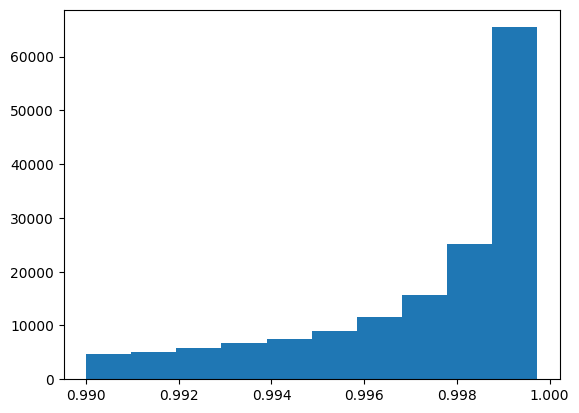

In [4]:
from matplotlib import pyplot as plt

plt.hist(dataset['train']['ref_tox'])

The model used 50k training entries (~1.5 hours of training).

In [5]:
n_train = 50000
n_val = 1000
ds_subset = dataset['train'].select(range(n_train + n_val))

dataset['train'] = ds_subset.select(range(n_train)) 
dataset['val'] = ds_subset.select(range(n_train, n_train+n_val))

In [6]:
max_input_length = 64
max_target_length = 64
batch_size = 128

In [7]:
# simple postprocessing for textgithub
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

## Metric

In [ ]:
def cleanup():
    '''Clean the RAM and VRAM from the trash'''

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def get_toxicity(preds, batch_size=1, device=None):
    '''Calculates toxicity of the corpus using RoBerta finetuned on toxicity classification.'''

    results = []

    model_name = 'SkolkovoInstitute/roberta_toxicity_classifier'

    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name)
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else device
    model.to(device)

    model.eval()
    for i in tqdm.tqdm(range(0, len(preds), batch_size)):
        batch = tokenizer(preds[i:i + batch_size], return_tensors='pt', max_length=-1, padding=True).to(device)

        with torch.no_grad():
            logits = model(**batch).logits
            out = torch.softmax(logits, -1)[:, 1].cpu().numpy()
            results.append(out)
    return 1 - np.concatenate(results)


def get_sacrebleu(inputs, preds):
    '''Calculates sacrebleu score for the inputs and predictions'''

    metric = evaluate.load("sacrebleu")

    result = metric.compute(predictions=preds, references=inputs)
    return result['score']


def get_fluency(preds, soft=False, batch_size=1, device=None):
    '''Calculates fluency of the corpus using RoBerta finetuned on CoLa dataset.'''

    model_name = 'cointegrated/roberta-large-cola-krishna2020'

    model = RobertaForSequenceClassification.from_pretrained(model_name)
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else device
    device = device
    model.to(device)

    results = []
    for i in trange(0, len(preds), batch_size):
        batch = [t for t in preds[i: i + batch_size]]
        inputs = tokenizer(batch, max_length=-1, padding=True, return_tensors='pt').to(device)
        with torch.no_grad():
            out = torch.softmax(model(**inputs).logits, -1)[:, 0].cpu().numpy()
            results.append(out)
    return np.concatenate(results)


def compute_metrics(eval_preds, tokenizer=None, print_results=False, batch_size=1, device='cuda', model_name=""):
    ''' Computing metrics for the given data

    Parameters:
    eval_preds=(preds, labels) -- tuple with predictions and labels
    tokenzier -- the tokenizer for the sequence. Default: None, and sequence is treated as decoded one
    model_name -- optional model name for fancy output printing. Defaul: empty'''

    preds, labels = eval_preds

    if tokenizer is not None:
        detokenized_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        filtered_labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        detokenized_labels = tokenizer.batch_decode(filtered_labels, skip_special_tokens=True)
    else:
        detokenized_preds = preds
        detokenized_labels = labels

    results = {}
    results['toxic'] = get_toxicity(detokenized_preds, batch_size=batch_size, device=device)
    results['avg_toxic'] = sum(results['toxic']) / len(results['toxic'])
    cleanup()

    results['bleu'] = get_sacrebleu(detokenized_labels, detokenized_preds) / 100
    cleanup()

    results['fluency'] = get_fluency(detokenized_preds, batch_size=batch_size, device=device)
    results['avg_fluency'] = sum(results['fluency']) / len(results['fluency'])
    cleanup()

    # count metrics
    results['joint'] = sum(results['toxic'] * results['bleu'] * results['fluency']) / len(preds)
    if print_results:
        if model_name != "":
            print("--------------")
            print(model_name)
        print("--------------")
        print("Metric   | Value")
        print("--------------")
        print(f"toxic    | {results['avg_toxic']:.2f}")
        print(f"bleu (n) | {results['bleu']:.2f}")
        print(f"fluency  | {results['avg_fluency']:.2f}")
        print("===============")
        print(f"Total    | {results['joint']:.2f}")
        print("--------------")
    return results


In [9]:
compute_metrics((dataset['val']['reference'], dataset['val']['translation']), print_results=True, batch_size=batch_size)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

--------------
Metric   | Value
--------------
toxic    | 0.01
bleu (n) | 0.22
fluency  | 0.89
Total    | 0.00
--------------


{'avg_toxic': 0.00950186425447464,
 'bleu': 0.22127326222502616,
 'fluency': 0.8942929763300345,
 'joint': 0.0019426810200225192}

# The model


Loading T5 model 

In [10]:
# selecting model checkpoint
model_type = "t5-small"

The model utilizes pretrained tokenizer

In [11]:
t5_tokenizer = AutoTokenizer.from_pretrained(model_type, )

def t5_wrapper(text):
    wrapped = f"Make the following sentence non-toxic: '{text}'"
    return wrapped

def t5_preprocess_function(examples):
    inputs = [t5_wrapper(ref) for ref in examples["reference"]]
    targets = [tsn for tsn in examples["translation"]]
        
    model_inputs = t5_tokenizer(inputs, max_length=max_input_length, truncation=True)
    labels = t5_tokenizer(targets, max_length=max_target_length, truncation=True)
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


Preprocessing datasets and tokenizing them.

In [12]:
t5_tokenized_datasets = dataset.map(
    t5_preprocess_function, 
    batched=True,
    batch_size=batch_size, 
    load_from_cache_file=False,
    remove_columns=dataset["train"].column_names,
)

  0%|          | 0/391 [00:00<?, ?ba/s]

  0%|          | 0/136 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Initializing model and arguments

In [13]:
t5_model = AutoModelForSeq2SeqLM.from_pretrained(model_type)
model_name = model_type.split("/")[-1]
t5_args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-detoxification",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=10,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    report_to='tensorboard',
)
t5_data_collator = DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model)
t5_trainer = Seq2SeqTrainer(
    t5_model,
    t5_args,
    train_dataset=t5_tokenized_datasets["train"],
    eval_dataset=t5_tokenized_datasets["val"],
    data_collator=t5_data_collator,
    tokenizer=t5_tokenizer,
    compute_metrics=lambda x: compute_metrics(x, t5_tokenizer, batch_size=batch_size)
)

In [15]:
t5_trainer.train()
# saving model
t5_trainer.save_model('t5_best')

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Avg Toxic,Bleu,Fluency,Joint
1,No log,1.993625,0.612286,0.224723,0.815205,0.109771
2,2.322900,1.933838,0.664574,0.231422,0.808446,0.121852
3,2.105600,1.903278,0.711058,0.234714,0.800925,0.131020
4,2.061800,1.883212,0.718938,0.238349,0.802042,0.135302
5,2.061800,1.868907,0.728295,0.239202,0.805758,0.138587
6,2.032600,1.856105,0.742909,0.241249,0.805957,0.142618
7,2.011700,1.844848,0.748053,0.244327,0.809981,0.146183
8,1.993500,1.832563,0.751767,0.246269,0.812085,0.148598
9,1.975400,1.827323,0.752121,0.246607,0.810365,0.148746
10,1.975400,1.825477,0.751134,0.246827,0.811284,0.148740


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.28it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.16it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.19it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.12it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.07it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.21it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.02it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8/8 [00:00<00:00,  9.13it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

## Evaluation

Now, let's generate a prediction for the test dataset

In [23]:
t5_model.from_pretrained('domrachev03/t5_detox')
t5_model.eval()
t5_model.config.use_cache = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

results = []
msgs = [t5_wrapper(text) for text in dataset["test"]["reference"]]
for i in trange(0, len(msgs), batch_size):
    batch = msgs[i: i+batch_size]
    tokenized_batch = t5_tokenizer(batch, max_length=128, padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        output = t5_model.generate(tokenized_batch['input_ids'])
        result = [t5_tokenizer.decode(out_i, skip_special_tokens=True,temperature=0) for out_i in output]
        if i == 0:
            print(result)
    results.extend(result)

  0%|          | 0/136 [00:00<?, ?it/s]

["if they say they don't want your help, you can bet they really need", 'when you go home, they\'ll call you "Mr. No-Legs', "Sanders ain't going for that late shit.", 'I want every one of them to hear.', 'that hurt.', "how do I know if I tell you what you need to know... that you're", "this guy doesn't go nowhere.", "I'm gonna be a little sucked if I can remember.", 'I sat one stitch and he looks at me now as if I were number', 'meet my lovely assistant... Tiny tits.', 'when you finish this, mats, you want to be near the front door.', "this doesn't count.", 'all expenses paid trip to the Big Apple.', "You're dating a new Jersey man?", 'they gave you a pardon, what do you do?', 'a slap.', 'he wants to kill him, you know.', "you're living, Luke.", 'We tried.', "the man is a savage, he puts all of Milverton'", 'look at this.', '"I said, yes, we talked about something else, but it was very personal, and', "he's gonna be a budget!", 'Did you find a potato without those nipples?', 'You owe m

And now, let's compute the metrics:

In [24]:
compute_metrics((results, dataset['test']['translation']), print_results=True, batch_size=batch_size)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 136/136 [00:14<00:00,  9.63it/s]


  0%|          | 0/136 [00:00<?, ?it/s]

--------------
Metric   | Value
--------------
toxic    | 0.74
bleu (n) | 0.24
fluency  | 0.83
Total    | 0.15
--------------


{'avg_toxic': 0.7429000455613011,
 'bleu': 0.23965065205523783,
 'fluency': 0.8310913368310638,
 'joint': 0.14680411506113675}

Final step is to save results of generation as `csv` file:

## Saving

Two things to save:
1. Finetuned model
2. Predictions on the test set

The model would be stored on the [HuggingFace](https://huggingface.co/domrachev03/t5_detox/tree/main):

In [ ]:
t5_model.save_pretrained('domrachev03/t5_detox')

And the predictions would be stored locally at `data/models_test_data`:

In [28]:
import pandas as pd

preds_dict = pd.DataFrame([[orig_i, pred_i, label_i] for orig_i, pred_i, label_i in zip(dataset['test']['reference'], results, dataset['test']['translation'])], columns=['Query', 'Predictions', 'Labels'])

preds_dict.head(10)

,Query,Predictions,Original values
0,"If they say they don't want your help, you can...","if they say they don't want your help, you can...","if they say they don't need help, you can bet ..."
1,"When you go home, they'il call you ""Mr. No-Leg...","when you go home, they'll call you ""Mr. No-Legs","when you get home, they'll call you Mr."
2,Mrs. Sanders ain't goingfor that late shit no ...,Sanders ain't going for that late shit.,Mrs. Sanders is not curious about being late.
3,I want every bloody one of them to hear.,I want every one of them to hear.,I want everyone to hear it.
4,That shit hurt.,that hurt.,and that really hurts.
5,How do I know if I tell you what you need to k...,how do I know if I tell you what you need to k...,how do I know if I tell you what you want to k...
6,"This guy ain't going nowhere. Oh, shit!",this guy doesn't go nowhere.,this guy's not going anywhere.
7,Fucked if I can remember.,I'm gonna be a little sucked if I can remember.,if only I could remember.
8,I fucked one stitch and he looks at me now as ...,I sat one stitch and he looks at me now as if ...,"I mess up a suture, and now he's looking at me..."
9,Earth! Meet my lovely assistant... Tiny tits.,meet my lovely assistant... Tiny tits.,"please welcome my beautiful assistant, Maloprs..."


In [29]:
preds_dict.to_csv('t5_test.csv')